In [1]:
import cfgrib
import xarray as xr

import pandas as pd
import numpy as np

from pyPhenology import models, utils
import numpy as np

from tqdm import trange, tqdm

import matplotlib.pyplot as plt

from warnings import warn

In [448]:
def aic(obs, pred, n_param):
        return len(obs) * np.log(np.mean((obs - pred)**2)) + 2*(n_param + 1)

observations, predictors = utils.load_test_data(name='vaccinium',
                                                phenophase='budburst')

default_models = [models.ThermalTime(), models.FallCooling(), models.M1(), models.MSB()]

default_model_names = ['ThermalTime', "FallCooling", "M1", "MSB"]

def train_ripeness(observations, predictors, test_observations, test_predictors, models=['ThermalTime']):

    
    # set up model comparisons
    best_aic=np.inf
    best_model = None
    best_model_name = None

    # iterate through all models
    for model_name in models:
        print("running model {m}".format(m=model_name))
        
        Model = utils.load_model(model_name)
        model = Model()
        model.fit(observations, predictors, optimizer_params='practical')
        
        # predict from test observations
        print("making predictions for model {m}".format(m=model_name))        
        preds = model.predict(test_observations, test_predictors)
        
        #print(preds)
        test_days = test_observations.doy.values
        #print(test_days)
        # this isn't valid - need to filter by site IDs
        
        # THIS IS REALLY BAD:
        test_days = test_days[0:len(preds)]
        #print(test_days)
        
        # score model
        model_aic = aic(obs = test_days,
                        pred=preds,
                        n_param = len(model.get_params()))
        print(model_aic)

        if model_aic < best_aic:
            best_model = model
            best_model_name = model_name
            best_aic = model_aic

        print('model {m} got an aic of {a}'.format(m=model_name,a=model_aic))

    print('Best model: {m}'.format(m=best_model_name))
    print('Best model paramters:')
    print(best_model.get_params())
    
    ripeness_data = observations_test
    ripeness_data['flowering_day'] = preds
    
    return ripeness_data

In [479]:
def train_ripeness_percent(observations, predictors, test_percent, models=['ThermalTime']):
    test_observations = observations.sample(frac=test_percent)
    observations_train = observations.drop(test_observations.index)
    
    # set up model comparisons
    best_aic=np.inf
    best_model = None
    best_model_name = None

    # iterate through all models
    for model_name in models:
        print("running model {m}".format(m=model_name))
        
        Model = utils.load_model(model_name)
        model = Model()
        model.fit(observations_train, predictors, optimizer_params='practical')
        
        # predict from test observations
        print("making predictions for model {m}".format(m=model_name))        
        preds = model.predict(test_observations, predictors)
        
        # for now.
        return preds
    
        #print(preds)
        test_days = test_observations.doy.values
        #print(test_days)
        
        # THIS IS REALLY BAD:
        test_days = test_days[0:len(preds)]
        #print(test_days)
        
        # score model
        model_aic = aic(obs = test_days,
                        pred=preds,
                        n_param = len(model.get_params()))
        print(model_aic)

        if model_aic < best_aic:
            best_model = model
            best_model_name = model_name
            best_aic = model_aic

        print('model {m} got an aic of {a}'.format(m=model_name,a=model_aic))

    print('Best model: {m}'.format(m=best_model_name))
    print('Best model paramters:')
    print(best_model.get_params())
    
    ripeness_data = observations_test
    ripeness_data['flowering_day'] = preds
    
    return ripeness_data

In [3]:
def ripeness_data_to_dict(ripeness_data):
    final_ripeness_data = ripeness_data[(ripeness_data.species == species) & (ripeness_data.site_id == site_id)]
    
    mean_maturation = np.mean(final_ripeness_data['flowering_day'])
    
    prediction_dict = {
        "full_flowering_data": final_ripeness_data,
        "species_site_flowering days": list(final_ripeness_data['flowering_day']),
        "mean_flowering_day": np.mean(final_ripeness_data['flowering_day'])
    }
    
    return prediction_dict

In [500]:
grib_data = cfgrib.open_datasets('../data/weather_data.grib')

In [516]:
core_data = grib_data[0]

In [62]:
apple_data = pd.read_csv('../data/plant phenology/malus.csv')

apple_data["lon_360"] = apple_data["LON"] % 360

apple_data

,YEAR,DAY,genus,specificEpithet,eventRemarks,LON,LAT,site_id,lon_360
0,2020,301,Malus,sieboldii,Ripe fruits,-92.623810,44.861355,1,267.376190
1,2020,352,Malus,sieboldii,Ripe fruits,-92.623810,44.861355,1,267.376190
2,2020,330,Malus,sieboldii,Ripe fruits,-92.623810,44.861355,1,267.376190
3,2020,265,Malus,sieboldii,Ripe fruits,-92.623810,44.861355,1,267.376190
4,2020,317,Malus,sieboldii,Ripe fruits,-92.623810,44.861355,1,267.376190
...,...,...,...,...,...,...,...,...,...
325415,2018,245,Malus,NaN,Ripe fruits,5.769571,45.199329,1759237,5.769571
325416,2019,221,Malus,NaN,Ripe fruits,-1.029497,51.440201,1759234,358.970503
325417,2016,196,Malus,pumila 'Green Sweet',Ripe fruits,-96.090696,41.291145,1582438,263.909304
325418,2016,196,Malus,NaN,Ripe fruits,-96.090696,41.291145,1582438,263.909304


## This is where I'm filtering weather data and correlating it with sites.

In [526]:
print(min(apple_data['LAT']))
print(max(apple_data['LAT']))

print(min(apple_data['lon_360']))
print(max(apple_data['lon_360']))

-45.6523817
64.84270041
0.008314
359.993043


(array([6.30000e+01, 1.31320e+04, 1.18776e+05, 7.37760e+04, 6.91000e+03,
        1.47900e+03, 6.84000e+02, 5.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 8.00000e+00,
        4.50000e+01, 3.50000e+01, 3.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 4.00000e+00, 3.00000e+00, 5.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        4.54000e+02, 2.78000e+02, 5.10000e+01, 8.70

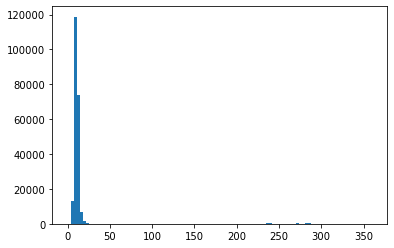

In [529]:
plt.hist(apple_data['lon_360'], bins=100)

In [220]:
concentrated_apples = apple_data[(apple_data['lon_360'] >= 5) & (apple_data['lon_360'] <= 17)]

concentrated_apples = concentrated_apples[concentrated_apples['YEAR'] >= 2010].drop_duplicates()

In [221]:
concentrated_apples

,YEAR,DAY,genus,specificEpithet,eventRemarks,LON,LAT,site_id,lon_360
1275,2012,238,Malus,domestica,Ripe fruits,11.658900,47.270800,101,11.658900
1276,2012,269,Malus,domestica,Ripe fruits,14.133900,47.899700,102,14.133900
1277,2013,232,Malus,domestica,Ripe fruits,16.271900,48.191400,103,16.271900
1278,2013,268,Malus,domestica,Ripe fruits,14.133900,47.899700,102,14.133900
1331,2010,253,Malus,domestica,Ripe fruits,13.233300,47.783300,108,13.233300
...,...,...,...,...,...,...,...,...,...
325281,2017,241,Malus,pumila 'Gala',Ripe fruits,5.962967,45.347083,1592534,5.962967
325300,2016,196,Malus,pumila,Ripe fruits,15.504940,51.932196,1516464,15.504940
325330,2016,291,Malus,pumila,Ripe fruits,10.392389,53.214127,1519662,10.392389
325331,2016,291,Malus,pumila,Ripe fruits,10.396832,53.209508,1519661,10.396832


In [511]:
print(min(concentrated_apples['LAT']))
print(max(concentrated_apples['LAT']))

print(min(concentrated_apples['lon_360']))
print(max(concentrated_apples['lon_360']))

44.533
55.7140867
5.064286
16.98534


(array([1.02000e+02, 3.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 1.56900e+03, 2.04177e+05, 1.16140e+04]),
 array([-45.6523817 , -34.60287349, -23.55336528, -12.50385707,
         -1.45434886,   9.59515935,  20.64466757,  31.69417578,
         42.74368399,  53.7931922 ,  64.84270041]),
 <BarContainer object of 10 artists>)

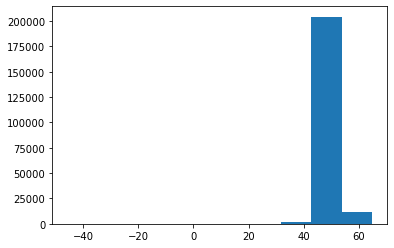

In [533]:
plt.hist(apple_data['LAT'])

In [530]:
core_data

<xarray.Dataset>
Dimensions:     (time: 162, latitude: 1801, longitude: 3600)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2010-01-01T08:00:00 ... 2023-06-01T08:0...
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude   (longitude) float64 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
    valid_time  (time) datetime64[ns] ...
Data variables:
    skt         (time, latitude, longitude) float32 nan nan nan ... 221.5 221.5
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [531]:
concentrated_weather = core_data.where(
                                        (core_data.longitude <= 18) & 
                                       (core_data.longitude >= 5), drop=True)

In [532]:
concentrated_weather

<xarray.Dataset>
Dimensions:     (time: 162, latitude: 1801, longitude: 130)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2010-01-01T08:00:00 ... 2023-06-01T08:0...
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude   (longitude) float64 5.1 5.2 5.3 5.4 5.5 ... 17.7 17.8 17.9 18.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    skt         (time, latitude, longitude) float32 nan nan nan ... 221.5 221.5
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [504]:
def get_site_history(weather_array, site_id, site_lat, site_lon):
    filtered = weather_array.where((abs(weather_array.latitude - site_lat) <= 0.05) & (abs(weather_array.longitude - site_lon) <= 0.05), drop=True)
    
    #print("Converting GRIB to dataframe")
    site_df = filtered.to_dataframe().drop(["number", "step", "surface"], axis=1).reset_index().rename(columns={"skt":"temperature"})
    
    site_df['site_id'] = site_id
    
    site_df['year'] = site_df.time.dt.to_period('Y')
    site_df['doy'] = site_df.time.dt.strftime('%j').astype(int)
    
    site_df = site_df[['site_id', 'temperature', 'year', 'doy', 'latitude', 'longitude']]
    
    return(site_df)

In [505]:
site_histories = []

for index, row in tqdm(concentrated_apples.iterrows()):
    
    site_histories.append(get_site_history(concentrated_weather, row['site_id'], row['LAT'], row['lon_360']))

full_site_histories = pd.concat(site_histories)

7844it [01:24, 93.29it/s] 


KeyboardInterrupt: 

In [ ]:
full_site_histories

### Preparing claudia's data for training 

In [354]:
def claudia_observations_to_pyphenology(claudia_obs):
    new_observations = claudia_obs.copy(deep=True)
    
    new_observations.rename(columns={'YEAR': 'year',
                            'DAY': 'doy',
                            'genus': 'species',
                            'LAT': 'latitude'}, inplace=True)
    
    new_observations.drop(['specificEpithet', 'eventRemarks', 'LON', 'lon_360'], axis=1, inplace=True)
    
    new_observations['phenophase'] = 516
    
    return new_observations

In [355]:
example_observations_2 = claudia_observations_to_pyphenology(concentrated_apples)

In [356]:
example_observations_2

,year,doy,species,latitude,site_id,phenophase
1275,2012,238,Malus,47.270800,101,516
1276,2012,269,Malus,47.899700,102,516
1277,2013,232,Malus,48.191400,103,516
1278,2013,268,Malus,47.899700,102,516
1331,2010,253,Malus,47.783300,108,516
...,...,...,...,...,...,...
325281,2017,241,Malus,45.347083,1592534,516
325300,2016,196,Malus,51.932196,1516464,516
325330,2016,291,Malus,53.214127,1519662,516
325331,2016,291,Malus,53.209508,1519661,516


In [357]:
full_site_histories['year'] = full_site_histories['year'].astype(str).astype(int)
full_site_histories['site_id'] = full_site_histories['site_id'].astype(int)

In [360]:
leap_year_key = {60: 61, 
                 91: 92, 
                 121: 122, 
                 152: 153, 
                 182: 183, 
                 213: 214, 
                 244: 245, 
                 274: 275, 
                 305: 306, 
                 335: 336}

corrected_leap_year_histories = full_site_histories.replace({'doy': leap_year_key})

In [351]:
# MAKE A MODEL HERE

train_ripeness(example_observations_2, corrected_leap_year_histories, )

running model ThermalTime


/Users/peterbenson/opt/anaconda3/envs/seasonality/lib/python3.11/site-packages/pyPhenology/models/utils/misc.py:66: UserWarning: Dropped temperature data for doy 336 due to missing data. Most likely from leap year mismatch
  warn("""Dropped temperature data for doy {d} due to missing data. Most likely from leap year mismatch""".format(d=last_doy_column))
/Users/peterbenson/opt/anaconda3/envs/seasonality/lib/python3.11/site-packages/pyPhenology/models/utils/misc.py:81: UserWarning: Dropped 123 of 8490 observations because of missing data
 Missing data from: 
      site_id  year
1153     2786  2010
1154     2786  2011
1155     2786  2012
1156     2786  2013
1157     2786  2014
...       ...   ...
7973     6226  2015
8132     6286  2013
8183     6291  2012
8461  1719385  2017
8475  1067753  2015

[81 rows x 2 columns]
  warn('Dropped {n0} of {n1} observations because of missing data'.format(n0=n_dropped, n1=original_sample_size) +


making predictions for model ThermalTime
model ThermalTime got an aic of 14858.793336471828
Best model: ThermalTime
Best model paramters:
{'t1': 166.1331091250701, 'T': -8.071766673703332, 'F': 857.7437515427242}


/Users/peterbenson/opt/anaconda3/envs/seasonality/lib/python3.11/site-packages/pyPhenology/models/utils/misc.py:66: UserWarning: Dropped temperature data for doy 336 due to missing data. Most likely from leap year mismatch
  warn("""Dropped temperature data for doy {d} due to missing data. Most likely from leap year mismatch""".format(d=last_doy_column))
/Users/peterbenson/opt/anaconda3/envs/seasonality/lib/python3.11/site-packages/pyPhenology/models/utils/misc.py:81: UserWarning: Dropped 31 of 2123 observations because of missing data
 Missing data from: 
      site_id  year
33       3791  2015
113      4841  2013
186      7021  2015
328      3012  2013
395      6291  2012
603      3012  2012
666      6228  2010
763      3791  2012
766      3012  2010
821      6192  2011
830      4537  2012
919      6228  2011
964      6181  2014
1272     6228  2013
1293     3791  2013
1319     6181  2011
1320     3791  2010
1321     6192  2013
1414     3012  2014
1469     3290  2014
1517     3368  20

ValueError: Length of values (2092) does not match length of index (2123)

**Use Falling Fruit as the Test Data**

In [5]:
falling_fruit_data = pd.read_csv("../data/falling_fruit_data/observation_phenology.csv")

In [6]:
falling_fruit_data

,location_id,observation_id,lat,lng,date,stage,type_count,type_id,taxonomic_rank,taxonomic_rank_name,en_name,scientific_name,scientific_synonyms
0,1764646,43121,30.312322,-97.724329,2020-05-20,unripe fruit,1,93,8,species,Pecan,Carya illinoinensis,NaN
1,1762703,42400,-41.434854,147.156620,2020-03-06,ripe fruit,1,69,8,species,Quince,Cydonia oblonga,"Cydonia, Cydonia vulgaris"
2,1762705,42401,27.793812,-82.650576,2020-03-07,unripe fruit,1,18,8,species,Loquat,Eriobotrya japonica,NaN
3,1762706,42402,27.753815,-82.705272,2020-03-03,ripe fruit,1,18,8,species,Loquat,Eriobotrya japonica,NaN
4,1762813,42434,47.092503,8.522837,2020-03-13,ripe fruit,1,542,8,species,Wild garlic,Allium ursinum,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22616,1760441,41433,38.911485,-77.027211,2019-09-18,unripe fruit,1,445,6,genus,Fig,Ficus,NaN
22617,1760442,41434,38.911548,-77.027153,2019-09-18,ripe fruit,1,445,6,genus,Fig,Ficus,NaN
22618,1760828,41596,-37.766723,145.003393,2019-10-01,ripe fruit,1,17,6,genus,Lavender,Lavandula,NaN
22619,1760830,48608,40.763941,-111.849089,2021-06-09,ripe fruit,1,92,6,genus,Mulberry,Morus,NaN


In [7]:
def ff_to_pyphenology(ff_obs, species_name):
    new_observations = ff_obs.copy(deep=True)
    
    # process date into a year and doy
    # YYYY - mm - dd
    new_observations['date'] = pd.to_datetime(new_observations['date'])
    
    new_observations['year'] = new_observations.date.dt.to_period('Y')
    new_observations['doy'] = new_observations.date.dt.strftime('%j').astype(int)
    
    new_observations['species'] = species_name
    
    new_observations.rename(columns={
                            'lat': 'LAT',
                            'lng': 'LON',
                            'location_id': 'site_id'}, inplace=True)
    
    # get lon_360 for site ID
    
    new_observations.drop(['stage',
                           'date',
                           'type_count', 
                           'type_id', 
                           'taxonomic_rank',
                           'taxonomic_rank_name',
                            'en_name', 
                            'scientific_name',
                            'scientific_synonyms',
                            'observation_id'], axis=1, inplace=True)
    
    new_observations['phenophase'] = 516
    
    new_observations["lon_360"] = new_observations["LON"] % 360

    
    return new_observations

In [8]:
ff_apples = falling_fruit_data[(falling_fruit_data['scientific_name'].str.contains('Malus', na=False))
                               & (falling_fruit_data['stage'] == 'ripe fruit')]

#ff_apples['date'] = ff_apples['date'].astype(str).str[0:4].astype(int)

In [9]:
ff_processed = ff_to_pyphenology(ff_apples, 'Malus').drop_duplicates()

In [10]:
ff_processed

,site_id,LAT,LON,year,doy,species,phenophase,lon_360
49,1762346,48.377091,-4.309709,2019,279,Malus,516,355.690291
150,1719834,47.440224,-122.834565,2018,18,Malus,516,237.165435
193,1762407,52.925020,-1.200858,2020,5,Malus,516,358.799142
210,1762453,-37.587812,143.871556,2020,26,Malus,516,143.871556
224,1762510,37.340353,-121.819730,2020,33,Malus,516,238.180270
...,...,...,...,...,...,...,...,...
22568,1755244,40.005259,-105.131318,2018,281,Malus,516,254.868682
22582,1759237,45.199329,5.769571,2018,245,Malus,516,5.769571
22583,1759234,51.440201,-1.029497,2019,221,Malus,516,358.970503
22602,1582438,41.291145,-96.090696,2016,196,Malus,516,263.909304


In [22]:
ff_processed[ff_processed['year'] == '2023'][['LAT', 'LON']].round(0).drop_duplicates()

,LAT,LON
13742,-41.0,147.0
18438,39.0,-87.0
19006,-38.0,145.0
19123,38.0,-122.0
19198,-41.0,146.0
19772,-46.0,171.0
19784,-46.0,168.0
19792,-45.0,169.0
20178,-45.0,170.0


In [437]:
ff_sites = []

sample_sites = ff_processed.sample(30)

for index, row in tqdm(sample_sites.iterrows()):
    
    ff_sites.append(get_site_history(ff_concentrated_weather, row['site_id'], row['LAT'], row['lon_360']))

full_ff_sites = pd.concat(ff_sites)

30it [01:12,  2.41s/it]


In [438]:
full_ff_sites

,site_id,temperature,year,doy,latitude,longitude
0,1759350,271.773163,2010,1,52.8,357.6
1,1759350,272.446045,2010,32,52.8,357.6
2,1759350,275.825836,2010,60,52.8,357.6
3,1759350,281.173828,2010,91,52.8,357.6
4,1759350,284.318329,2010,121,52.8,357.6
...,...,...,...,...,...,...
157,1461,272.722778,2023,32,40.1,271.8
158,1461,274.741882,2023,60,40.1,271.8
159,1461,279.873596,2023,91,40.1,271.8
160,1461,285.650513,2023,121,40.1,271.8


In [439]:
len(sample_sites['site_id'].unique())

30

In [441]:
len(full_ff_sites['site_id'].unique())

30

In [428]:
ff_lat_ranges = [[30, 60], [-45, -30]]
ff_lon_ranges = [[0, 30], [140, 155], [225, 310], [350, 365]]

In [430]:
ff_concentrated_weather = core_data.where(((core_data.latitude <= 60) & 
                                           (core_data.latitude >= 30)) |
                                          ((core_data.latitude <= -30) &
                                            (core_data.latitude >= -45)) |
                                          ((core_data.longitude <= 30) &
                                            (core_data.longitude >= 0)) |
                                          ((core_data.longitude <= 155) &
                                            (core_data.longitude >= 140)) |
                                          ((core_data.longitude <= 310) &
                                            (core_data.longitude >= 255)) |
                                          ((core_data.longitude <= 365) &
                                            (core_data.longitude >= 350)), drop=True)

In [452]:
full_ff_sites[full_ff_sites['site_id'] == 1759350]

,site_id,temperature,year,doy,latitude,longitude
0,1759350,271.773163,2010,1,52.8,357.6
1,1759350,272.446045,2010,32,52.8,357.6
2,1759350,275.825836,2010,60,52.8,357.6
3,1759350,281.173828,2010,91,52.8,357.6
4,1759350,284.318329,2010,121,52.8,357.6
...,...,...,...,...,...,...
157,1759350,276.412231,2023,32,52.8,357.6
158,1759350,277.626648,2023,60,52.8,357.6
159,1759350,280.789612,2023,91,52.8,357.6
160,1759350,285.869263,2023,121,52.8,357.6


In [453]:
sample_sites

,site_id,LAT,LON,year,doy,species,phenophase,lon_360
12780,1759350,52.771323,-2.385224,2019,225,Malus,516,357.614776
22053,1519299,43.065458,-89.451178,2016,259,Malus,516,270.548822
12470,1755361,42.344726,-71.079272,2018,291,Malus,516,288.920728
22051,1519298,43.065799,-89.451182,2016,255,Malus,516,270.548818
15912,691256,48.432053,-123.379482,2016,253,Malus,516,236.620518
21380,1519571,40.463410,-79.929734,2016,282,Malus,516,280.070266
11581,1722639,47.668682,-122.416990,2018,233,Malus,516,237.583010
21987,1517825,49.032341,-122.866505,2016,251,Malus,516,237.133495
19570,1808295,-35.198981,149.214627,2022,52,Malus,516,149.214627
11860,1718623,42.799410,-84.962635,2017,276,Malus,516,275.037365


In [449]:
train_ripeness(example_observations_2, corrected_leap_year_histories, sample_sites, full_ff_sites)

running model ThermalTime


/Users/peterbenson/opt/anaconda3/envs/seasonality/lib/python3.11/site-packages/pyPhenology/models/utils/misc.py:66: UserWarning: Dropped temperature data for doy 336 due to missing data. Most likely from leap year mismatch
  warn("""Dropped temperature data for doy {d} due to missing data. Most likely from leap year mismatch""".format(d=last_doy_column))
/Users/peterbenson/opt/anaconda3/envs/seasonality/lib/python3.11/site-packages/pyPhenology/models/utils/misc.py:81: UserWarning: Dropped 154 of 10613 observations because of missing data
 Missing data from: 
       site_id  year
1315      2542  2011
1446      2786  2010
1447      2786  2011
1448      2786  2012
1449      2786  2013
...        ...   ...
9961      6226  2015
10153     6286  2013
10314     7021  2015
10578  1719385  2017
10593  1067753  2015

[85 rows x 2 columns]
  warn('Dropped {n0} of {n1} observations because of missing data'.format(n0=n_dropped, n1=original_sample_size) +


making predictions for model ThermalTime
nan
model ThermalTime got an aic of nan
Best model: None
Best model paramters:


/Users/peterbenson/opt/anaconda3/envs/seasonality/lib/python3.11/site-packages/pyPhenology/models/utils/misc.py:66: UserWarning: Dropped temperature data for doy 336 due to missing data. Most likely from leap year mismatch
  warn("""Dropped temperature data for doy {d} due to missing data. Most likely from leap year mismatch""".format(d=last_doy_column))
/Users/peterbenson/opt/anaconda3/envs/seasonality/lib/python3.11/site-packages/pyPhenology/models/utils/misc.py:81: UserWarning: Dropped 30 of 30 observations because of missing data
 Missing data from: 
    site_id  year
0   1759350  2019
1   1519299  2016
2   1755361  2018
3   1519298  2016
4    691256  2016
5   1519571  2016
6   1722639  2018
7   1517825  2016
8   1808295  2022
9   1718623  2017
10     3096  2022
11  1760645  2019
12  1760675  2019
13  1068903  2015
14  1718035  2017
15  1821211  2022
16  1759320  2017
17  1719236  2017
18  1519581  2016
19  1760744  2019
20  1805376  2021
21  1809296  2021
22  1769661  2020
23  180

AttributeError: 'NoneType' object has no attribute 'get_params'

missing data refers to weather data for that site at that year. It needs data for the entire year?

In [536]:
full_ff_sites[full_ff_sites['site_id'] == 1759350]

,site_id,temperature,year,doy,latitude,longitude
0,1759350,271.773163,2010,1,52.8,357.6
1,1759350,272.446045,2010,32,52.8,357.6
2,1759350,275.825836,2010,60,52.8,357.6
3,1759350,281.173828,2010,91,52.8,357.6
4,1759350,284.318329,2010,121,52.8,357.6
...,...,...,...,...,...,...
157,1759350,276.412231,2023,32,52.8,357.6
158,1759350,277.626648,2023,60,52.8,357.6
159,1759350,280.789612,2023,91,52.8,357.6
160,1759350,285.869263,2023,121,52.8,357.6


In [537]:
ff_processed[ff_processed['site_id'] == 1759350]

,site_id,LAT,LON,year,doy,species,phenophase,lon_360
12780,1759350,52.771323,-2.385224,2019,225,Malus,516,357.614776


In [464]:
ff_processed['site_id'].mode()

0    1065814
Name: site_id, dtype: int64

In [467]:
one_site = ff_processed[ff_processed['site_id'] == 1065814]

In [468]:
one_site

,site_id,LAT,LON,year,doy,species,phenophase,lon_360
17329,1065814,41.666101,-81.244858,2016,283,Malus,516,278.755142
17331,1065814,41.666101,-81.244858,2015,268,Malus,516,278.755142
17333,1065814,41.666101,-81.244858,2015,259,Malus,516,278.755142
17335,1065814,41.666101,-81.244858,2015,244,Malus,516,278.755142


In [472]:
list(one_site['site_id'])[0]

1065814

In [473]:
sample_ff_weather = get_site_history(core_data, list(one_site['site_id'])[0], 
                                     list(one_site['LAT'])[0], 
                                     list(one_site['lon_360'])[0])

In [474]:
train_ripeness(example_observations_2, corrected_leap_year_histories, one_site, sample_ff_weather)

running model ThermalTime


/Users/peterbenson/opt/anaconda3/envs/seasonality/lib/python3.11/site-packages/pyPhenology/models/utils/misc.py:66: UserWarning: Dropped temperature data for doy 336 due to missing data. Most likely from leap year mismatch
  warn("""Dropped temperature data for doy {d} due to missing data. Most likely from leap year mismatch""".format(d=last_doy_column))
/Users/peterbenson/opt/anaconda3/envs/seasonality/lib/python3.11/site-packages/pyPhenology/models/utils/misc.py:81: UserWarning: Dropped 154 of 10613 observations because of missing data
 Missing data from: 
       site_id  year
1315      2542  2011
1446      2786  2010
1447      2786  2011
1448      2786  2012
1449      2786  2013
...        ...   ...
9961      6226  2015
10153     6286  2013
10314     7021  2015
10578  1719385  2017
10593  1067753  2015

[85 rows x 2 columns]
  warn('Dropped {n0} of {n1} observations because of missing data'.format(n0=n_dropped, n1=original_sample_size) +


making predictions for model ThermalTime
nan
model ThermalTime got an aic of nan
Best model: None
Best model paramters:


/Users/peterbenson/opt/anaconda3/envs/seasonality/lib/python3.11/site-packages/pyPhenology/models/utils/misc.py:66: UserWarning: Dropped temperature data for doy 336 due to missing data. Most likely from leap year mismatch
  warn("""Dropped temperature data for doy {d} due to missing data. Most likely from leap year mismatch""".format(d=last_doy_column))
/Users/peterbenson/opt/anaconda3/envs/seasonality/lib/python3.11/site-packages/pyPhenology/models/utils/misc.py:81: UserWarning: Dropped 4 of 4 observations because of missing data
 Missing data from: 
   site_id  year
0  1065814  2016
1  1065814  2015
  warn('Dropped {n0} of {n1} observations because of missing data'.format(n0=n_dropped, n1=original_sample_size) +
/Users/peterbenson/opt/anaconda3/envs/seasonality/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/peterbenson/opt/anaconda3/envs/seasonality/lib/python3.11/site-packag

AttributeError: 'NoneType' object has no attribute 'get_params'

In [481]:
raw_preds = train_ripeness_percent(example_observations_2, corrected_leap_year_histories, 0.2)

running model ThermalTime


/Users/peterbenson/opt/anaconda3/envs/seasonality/lib/python3.11/site-packages/pyPhenology/models/utils/misc.py:66: UserWarning: Dropped temperature data for doy 336 due to missing data. Most likely from leap year mismatch
  warn("""Dropped temperature data for doy {d} due to missing data. Most likely from leap year mismatch""".format(d=last_doy_column))
/Users/peterbenson/opt/anaconda3/envs/seasonality/lib/python3.11/site-packages/pyPhenology/models/utils/misc.py:81: UserWarning: Dropped 132 of 8490 observations because of missing data
 Missing data from: 
      site_id  year
1043     2542  2011
1140     2786  2011
1141     2786  2012
1142     2786  2013
1271     3012  2011
...       ...   ...
7973     6226  2015
8125     6286  2013
8260     7021  2015
8465  1719385  2017
8475  1067753  2015

[82 rows x 2 columns]
  warn('Dropped {n0} of {n1} observations because of missing data'.format(n0=n_dropped, n1=original_sample_size) +


making predictions for model ThermalTime


/Users/peterbenson/opt/anaconda3/envs/seasonality/lib/python3.11/site-packages/pyPhenology/models/utils/misc.py:66: UserWarning: Dropped temperature data for doy 336 due to missing data. Most likely from leap year mismatch
  warn("""Dropped temperature data for doy {d} due to missing data. Most likely from leap year mismatch""".format(d=last_doy_column))
/Users/peterbenson/opt/anaconda3/envs/seasonality/lib/python3.11/site-packages/pyPhenology/models/utils/misc.py:81: UserWarning: Dropped 22 of 2123 observations because of missing data
 Missing data from: 
      site_id  year
8        4400  2013
43       6192  2012
169      6181  2013
303      4841  2013
344      4113  2011
414      3533  2015
436      6181  2011
439      6286  2011
440      6181  2014
554      2786  2010
656      4113  2010
691      6228  2014
847      3791  2015
1205     4113  2015
1271     6226  2012
1312     4841  2014
1473     3791  2013
1644     3012  2013
1745     2786  2014
1876     6291  2015
1947     4841  20

In [525]:
corrected_leap_year_histories.dropna()

,site_id,temperature,year,doy,latitude,longitude
0,101,259.818085,2010,1,47.3,11.7
1,101,263.887451,2010,32,47.3,11.7
2,101,271.296539,2010,61,47.3,11.7
3,101,278.962891,2010,92,47.3,11.7
4,101,281.216766,2010,122,47.3,11.7
...,...,...,...,...,...,...
157,1759237,267.416138,2023,32,45.2,5.8
158,1759237,277.179382,2023,61,45.2,5.8
159,1759237,282.219299,2023,92,45.2,5.8
160,1759237,287.517700,2023,122,45.2,5.8


Drop sites that have no weather data attached. 

In [483]:
np.mean(raw_preds)

245.2855782960495

In [488]:
np.std(raw_preds)

2.9130386057020377

Anecdotally, this seems to be right! Apples are usually ripe in the fall. 

(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   1.,   0.,   1.,   0.,   0.,   2.,   0.,   1.,   1.,   1.,
          3.,   2.,   9.,   8.,  14.,  19.,  38.,  39., 102.,  73., 170.,
        133., 349., 204., 348., 269., 441., 482., 282., 374., 181., 343.,
        132., 191., 103., 197.,  87., 105.,  72.,  99.,  76.,  99.,  63.,
        152., 136., 152., 208., 243., 215., 248., 357., 361., 456., 305.,
        460., 430., 377., 301., 323., 245., 178., 157.,  69.,  66.,  21.,
          9.,   8.,   7.,   4.,   2.,   2.,   2.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 85.  ,  87.53,  90.06,  92.59,  95.12,  97.65, 100.18, 102.71,
        105.24, 107.77, 110.3 , 112.83, 115.36, 117.89, 120.42, 122.95,
        125.48, 128.01, 130.54, 133.07, 135.6 , 138.13, 140.66, 143.19,
        145.72, 148.25, 150.78, 153.31, 155.84, 158.37, 160.9 , 163.43,
        165.96, 168.49, 171.02

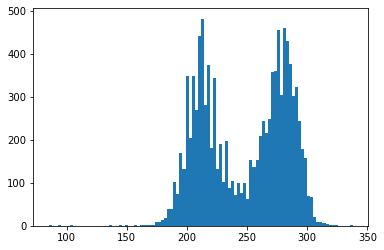

In [519]:
plt.hist(example_observations_2['doy'], bins=100)

In [494]:
example_observations_2[example_observations_2['site_id'] == 568]

,year,doy,species,latitude,site_id,phenophase
93214,2010,202,Malus,48.15,568,516
93215,2011,189,Malus,48.15,568,516
93216,2012,199,Malus,48.15,568,516
93217,2013,201,Malus,48.15,568,516
93218,2014,191,Malus,48.15,568,516
93219,2015,194,Malus,48.15,568,516
314061,2010,246,Malus,48.15,568,516
314062,2011,247,Malus,48.15,568,516
314063,2012,250,Malus,48.15,568,516
314064,2013,252,Malus,48.15,568,516


In [491]:
corrected_leap_year_histories[corrected_leap_year_histories['site_id'] == 568]

,site_id,temperature,year,doy,latitude,longitude
0,568,266.474335,2010,1,48.1,12.8
1,568,267.440186,2010,32,48.1,12.8
2,568,276.441071,2010,61,48.1,12.8
3,568,283.916016,2010,92,48.1,12.8
4,568,286.068329,2010,122,48.1,12.8
...,...,...,...,...,...,...
157,568,273.435669,2023,32,48.1,12.8
158,568,278.648132,2023,61,48.1,12.8
159,568,281.361877,2023,92,48.1,12.8
160,568,288.240356,2023,122,48.1,12.8


In [495]:
core_data.where((abs(core_data.latitude - 54.1) <= 0.05) & 
                (abs(core_data.longitude - 13.9) <= 0.05), drop=True).to_dataframe()

<xarray.Dataset>
Dimensions:     (time: 162, latitude: 1, longitude: 1)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2010-01-01T08:00:00 ... 2023-06-01T08:0...
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 54.1
  * longitude   (longitude) float64 13.9
    valid_time  (time) datetime64[ns] ...
Data variables:
    skt         (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [492]:
corrected_leap_year_histories[corrected_leap_year_histories['site_id'] == 4400]
# This temperature is NA for some reason.

,site_id,temperature,year,doy,latitude,longitude
0,4400,NaN,2010,1,54.1,13.9
1,4400,NaN,2010,32,54.1,13.9
2,4400,NaN,2010,61,54.1,13.9
3,4400,NaN,2010,92,54.1,13.9
4,4400,NaN,2010,122,54.1,13.9
...,...,...,...,...,...,...
157,4400,NaN,2023,32,54.1,13.9
158,4400,NaN,2023,61,54.1,13.9
159,4400,NaN,2023,92,54.1,13.9
160,4400,NaN,2023,122,54.1,13.9


In [498]:
core_data

<xarray.Dataset>
Dimensions:     (time: 162, latitude: 1801, longitude: 3600)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2010-01-01T08:00:00 ... 2023-06-01T08:0...
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude   (longitude) float64 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
    valid_time  (time) datetime64[ns] ...
Data variables:
    skt         (time, latitude, longitude) float32 nan nan nan ... 221.5 221.5
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [517]:
core_data.dropna('longitude', how='all')

<xarray.Dataset>
Dimensions:     (time: 162, latitude: 1801, longitude: 3600)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2010-01-01T08:00:00 ... 2023-06-01T08:0...
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude   (longitude) float64 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
    valid_time  (time) datetime64[ns] ...
Data variables:
    skt         (time, latitude, longitude) float32 nan nan nan ... 221.5 221.5
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts